In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

print(tf.__version__)


2.11.0


### Retrieve the data from the local datasets folder


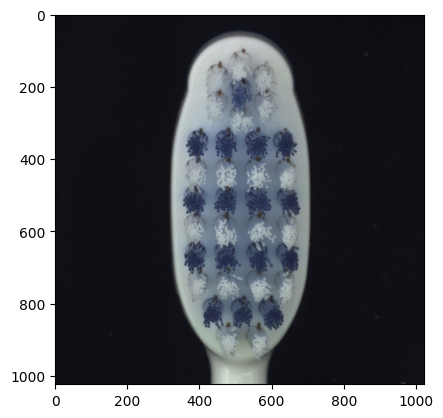

In [3]:
import os

TOOTHBRUSH_DATA_PATH = 'datasets/toothbrush'

TOOTHBRUSH_TRAIN_PATH = os.path.join(TOOTHBRUSH_DATA_PATH, 'train')
TOOTHBRUSH_GOOD_PATH = os.path.join(TOOTHBRUSH_TRAIN_PATH, 'good')

import matplotlib.pyplot as plt

import random

random_img = random.choice(os.listdir(TOOTHBRUSH_GOOD_PATH))

from skimage.io import imread
from skimage.transform import resize

sample_image = imread(os.path.join(TOOTHBRUSH_GOOD_PATH, random_img))
sample_image= sample_image.astype("float32")

plt.imshow(sample_image.astype('uint8'));


In [4]:
sample_image.shape

(1024, 1024, 3)

In [5]:
import numpy as np

def my_init(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype="float32")
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

# convolutional layer to make the image smaller and extract features
conv = tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), input_shape=(None, None, 3), kernel_initializer=my_init)

# spatial pyramid pooling layer
spp = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))

# use the convolutional layer to extract features
img_in = tf.expand_dims(sample_image, axis=0)

img_in.shape

TensorShape([1, 1024, 1024, 3])

In [6]:
img_out = conv(img_in)
img_out = spp(img_out)

img_out.shape

TensorShape([1, 255, 255, 3])

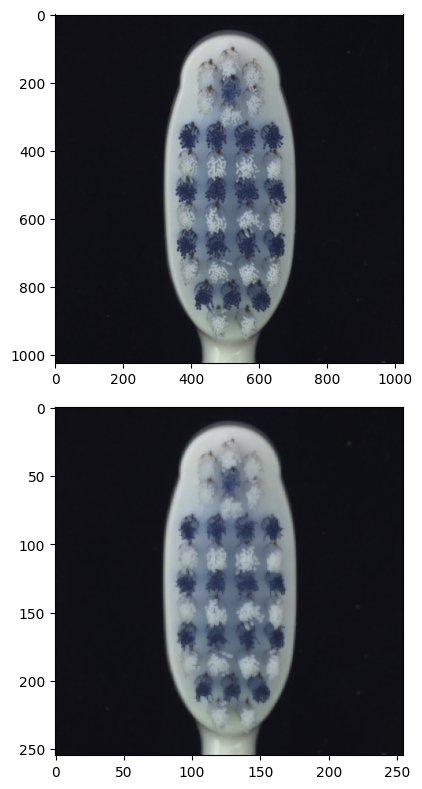

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

fig.tight_layout()
ax[0].imshow(img_in[0].numpy().astype('uint8'))
ax[1].imshow(img_out[0].numpy().astype('uint8'));

### Creating the model

In [43]:
from sspcab import sspcab_layer
tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)


class SPP(tf.keras.models.Model):
    def __init__(self, pool_size=(8, 8)):
        super(SPP, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), input_shape=(1024, 1024, 3), kernel_initializer=my_init)
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
        

    def call(self, inputs, training=False):
        y = self.conv(inputs)
        y = self.pool(y)
        y = sspcab_layer(inputs, name='ssbcap_0', kernel_dim=2, dilation=1, filters=3)
        
        y = self.flatten(y)
        
        y = self.dense(y)
        
        y = tf.squeeze(y, axis=1)
        
        return y

model = SPP()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


prediction = model.predict(img_in, steps=1) 

# the prediction is a binary classification of the image
# check if the model outputted good or bad
prediction = prediction[0].astype('uint8')

if prediction == 1:
    print('good')
else:
    print('bad')

# the prediction is a binary classification of the image
# check if the model outputted good or bad

# plt.imshow(prediction[0].astype('uint8'));


# reference: https://stackoverflow.com/questions/53804330/image-classification-using-keras-cnn-training-very-slowly
# for image preprocessing and augmentation to increase the number of training samples 
# also for data splitting into training and validation sets and loading the data into the model slowly


1/1 [==============================] - 0s 169ms/step
good


In [47]:
print(model.summary())

Model: "spp_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_167 (Conv2D)         multiple                  228       
                                                                 
 max_pooling2d_35 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 flatten_34 (Flatten)        multiple                  0         
                                                                 
 dense_100 (Dense)           multiple                  3145729   
                                                                 
Total params: 3,145,957
Trainable params: 3,145,957
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        'datasets/toothbrush/train',
        target_size=(1024, 1024), #since 64,64,pixels
        batch_size=32,
        class_mode='binary')

test_set= test_datagen.flow_from_directory(
        'datasets/toothbrush/test',
        target_size=(1024, 1024),
        batch_size=32,
        class_mode='binary')

model.fit_generator(
    training_set,
    steps_per_epoch=2,
    epochs=25,
    validation_data=test_set,
    validation_steps=1
)



Found 60 images belonging to 1 classes.
Found 42 images belonging to 2 classes.


C:\Users\AzqzPC\AppData\Local\Temp\ipykernel_206708\3967583414.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/25
(28, 1024, 1024, 3)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [28] vs. [28,1024,1024,3] [Op:Mul]